# Homework I: Optimization and Basic Neural Networks





In [1]:
import jax
import jax.numpy as jnp
from jax import lax
import numpy as np
import matplotlib.pyplot as plt

# Region for the assignment
x_min, x_max = -5*jnp.pi/2, 5*jnp.pi/2   # [-5π/2, 5π/2]
y_min, y_max = -2*jnp.pi,   2*jnp.pi     # [-2π,   2π]

print('Region x:', float(x_min), 'to', float(x_max))
print('Region y:', float(y_min), 'to', float(y_max))


Region x: -7.853981633974483 to 7.853981633974483
Region y: -6.283185307179586 to 6.283185307179586


Define $C$, gradient, and Hessian (JAX autodiff method)

In [2]:
def C_vec(r: jnp.ndarray) -> jnp.ndarray:
    # Pure-JAX definition of C(x,y) with r = [x, y]. Returns a scalar.
    x, y = r[0], r[1]
    return 0.5 * (jnp.cos(x)**2 + jnp.sin(y)**2)

def C(x: jnp.ndarray, y: jnp.ndarray) -> jnp.ndarray:
    # Convenience wrapper for separate x,y inputs (useful for plotting).
    return C_vec(jnp.array([x, y]))

# Autodiff
gradC_vec    = jax.grad(C_vec)       # R^2 -> R^2
hessianC_vec = jax.hessian(C_vec)    # R^2 -> R^{2x2}

# JIT wrappers (SPEED ....woooshh)
C_vec_jit        = jax.jit(C_vec)
gradC_vec_jit    = jax.jit(gradC_vec)
hessianC_vec_jit = jax.jit(hessianC_vec)

print('C(0,0) =', float(C_vec_jit(jnp.array([0.0,0.0]))))
print('∇C(0,0) =', gradC_vec_jit(jnp.array([0.0,0.0])))
print('H(0,0) =\n', hessianC_vec_jit(jnp.array([0.0,0.0])))



C(0,0) = 0.5
∇C(0,0) = [0. 0.]
H(0,0) =
 [[-1.  0.]
 [ 0.  1.]]


## Evaluate $C$ on a grid

In [3]:
Nx, Ny = 300, 200 # since (x range > y range , x needs more resolution)
xx = jnp.linspace(x_min, x_max, Nx)
yy = jnp.linspace(y_min, y_max, Ny)
XX, YY = jnp.meshgrid(xx, yy, indexing='xy')   # shapes (Ny, Nx), indexing = cartesian

pts = jnp.stack([XX.ravel(), YY.ravel()], axis=1) # (Ny*Nx, 2)
Ny_, Nx_ = XX.shape

# Vectorize C_vec over the list of points
C_batch = jax.vmap(C_vec_jit)(pts)
C_grid = C_batch.reshape(YY.shape)                    # (Ny, Nx)

# Evaluate gradient at all points: (N,2)
G_all = jax.vmap(gradC_vec_jit)(pts)
# Evaluate Hessian at all points: (N,2,2)
H_all = jax.vmap(hessianC_vec_jit)(pts)

# Reshape back to grid forms
grad_grid = G_all.reshape(Ny_, Nx_,2)
H_grid = H_all.reshape(Ny_, Nx_, 2, 2)          # Hessian at each grid cell


print('Grid shapes:', XX.shape, YY.shape,grad_grid.shape, H_grid.shape)

Grid shapes: (200, 300) (200, 300) (200, 300, 2) (200, 300, 2, 2)


## Estimate approach

In [4]:
import jax
import jax.numpy as jnp

# ---- Core: generalized, estimation-based critical point finder ----
def estimate_critical_points(
    C_vec,
    x_range, y_range,
    Nx=300, Ny=200,        # grid resolution (used when mode="grid")
    tol_grad=1e-2,         # gradient-norm threshold (your 0.01 "coverage" knob)
    eig_tol=1e-10,         # Hessian eigenvalue tolerance
    refine=True,           # do a few damped Newton refinement steps
    refine_steps=3,
    refine_ridge=1e-3,     # ridge for H regularization in Newton steps
    nms_radius=2           # non-maximum suppression radius (in grid index units)
):
    """
    Estimate critical points by sampling grid, filtering by ||grad||,
    optional Newton refinement, and Hessian-eigenvalue classification.

    Returns: list of dicts with keys: x, y, C, type, grad_norm, eigvals
    """
    gradC = jax.grad(C_vec)
    hessC = jax.hessian(C_vec)
    C_vec_jit   = jax.jit(C_vec)
    gradC_jit   = jax.jit(gradC)
    hessC_jit   = jax.jit(hessC)

    x_min, x_max = x_range
    y_min, y_max = y_range

    # ---------- 1) Build candidate evaluation points ----------

    xx = jnp.linspace(x_min, x_max, Nx)
    yy = jnp.linspace(y_min, y_max, Ny)
    XX, YY = jnp.meshgrid(xx, yy, indexing="xy")        # (Ny, Nx)
    pts = jnp.stack([XX.ravel(), YY.ravel()], axis=1)   # (N, 2)
    Ny_, Nx_ = YY.shape[0], XX.shape[1]
    def nms_on_indices(idxs_flat, radius=nms_radius):
        # idxs_flat: 1D jnp.array of flat indices to keep sparsely
        # simple greedy NMS in index space (CPU-friendly). Convert to Python for compactness.
        idxs = list(map(int, list(idxs_flat)))
        kept = []
        taken = set()
        for k in idxs:
            if k in taken:
                continue
            # keep k; suppress neighbors within Chebyshev radius in grid coords
            kept.append(k)
            i, j = divmod(k, Nx_)
            for di in range(-radius, radius+1):
                for dj in range(-radius, radius+1):
                    ii = i+di; jj = j+dj
                    if 0 <= ii < Ny_ and 0 <= jj < Nx_:
                        taken.add(ii*Nx_ + jj)
        return jnp.array(kept, dtype=jnp.int32)


    # ---------- 2) Evaluate grad, grad-norm; prefilter by tol_grad ----------
    G = jax.vmap(gradC_jit)(pts)                    # (N,2)
    gnorm = jnp.linalg.norm(G, axis=1)              # (N,)
    cand = jnp.where(gnorm < tol_grad)[0]           # indices of small-gradient points

    if cand.size == 0:
        return []

    # Optional: sort candidates by ascending grad-norm (best first)
    cand = cand[jnp.argsort(gnorm[cand])]

    # Apply NMS (grid mode) to avoid duplicates in a small neighborhood
    cand = nms_on_indices(cand)

    # ---------- 3) Optional: Newton refinement on each candidate ----------
    def newton_refine(r0):
        # Damped Newton: r_{k+1} = r_k - (H + λI)^{-1} g
        def step(r, _):
            g = gradC_jit(r)
            H = hessC_jit(r)
            H_reg = H + refine_ridge * jnp.eye(2)
            delta = jnp.linalg.solve(H_reg, g)
            r_new = r - delta
            # project back to box
            rx = jnp.clip(r_new[0], x_min, x_max)
            ry = jnp.clip(r_new[1], y_min, y_max)
            return jnp.array([rx, ry]), None
        r_final, _ = jax.lax.scan(step, r0, jnp.arange(refine_steps))
        return r_final

    if refine:
        refined_pts = jax.vmap(newton_refine)(pts[cand])
    else:
        refined_pts = pts[cand]

    # ---------- 4) Classify by Hessian eigenvalues at refined points ----------
    Hs   = jax.vmap(hessC_jit)(refined_pts)         # (M,2,2)
    vals = jax.vmap(C_vec_jit)(refined_pts)         # (M,)
    # grads= jax.vmap(gradC_jit)(refined_pts)         # (M,2)
    # gns  = jnp.linalg.norm(grads, axis=1)           # (M,)
    eigs = jax.vmap(jnp.linalg.eigvals)(Hs)         # (M,2)

    all_pos = jnp.all(eigs >  eig_tol, axis=1)
    all_neg = jnp.all(eigs < -eig_tol, axis=1)
    kinds = jnp.where(all_pos, 0, jnp.where(all_neg, 1, 2))  # 0=min, 1=max, 2=saddle

    # ---------- 5) Package results (drop obvious duplicates by value/coord) ----------
    out = []
    M = refined_pts.shape[0]
    for k in range(M):
        xk, yk = float(refined_pts[k,0]), float(refined_pts[k,1])
        out.append({
            "x": xk,
            "y": yk,
            "C": float(vals[k]),
            "type": ["local minimum","local maximum","saddle / indefinite"][int(kinds[k])],
            # "grad_norm": gns[k],
            # "eigvals": tuple(eigs[k])
        })
    return out


Theory:
## Deriving the critical point conditions

We start with the cost function:

$[
C(x,y) = \tfrac{1}{2} \left( \cos^2 x + \sin^2 y \right)
$]

---

### Step 1: Take the gradient

$[
\nabla C(x,y) =
\left[ \frac{\partial C}{\partial x}, \; \frac{\partial C}{\partial y} \right]
$]

**Partial w.r.t. \(x\):**

$[
\frac{\partial C}{\partial x}
= \tfrac{1}{2} \cdot 2 \cos(x)(- \sin(x))
= -\cos(x)\sin(x)
$]

Using the trig identity $(\sin(2x) = 2\sin(x)\cos(x)$):

$[
\frac{\partial C}{\partial x} = -\tfrac{1}{2}\sin(2x)
$]

---

**Partial w.r.t. \(y\):**

$[
\frac{\partial C}{\partial y}
= \tfrac{1}{2} \cdot 2 \sin(y)\cos(y)
= \sin(y)\cos(y)
$]

Using the identity $(\sin(2y) = 2\sin(y)\cos(y)$):

$[
\frac{\partial C}{\partial y} = \tfrac{1}{2}\sin(2y)
$]

---

### Step 2: Critical point condition

Critical points occur when the gradient is zero:

$[
\nabla C(x,y) = (0,0)
$]

So:

$[
\frac{\partial C}{\partial x} = -\tfrac{1}{2}\sin(2x) = 0
\quad\Longrightarrow\quad \sin(2x) = 0
$]

$[
\frac{\partial C}{\partial y} = \tfrac{1}{2}\sin(2y) = 0
\quad\Longrightarrow\quad \sin(2y) = 0
$]

---

### Step 3: Solve

- $(\sin(2x)=0 \;\Rightarrow\; 2x = n\pi \;\Rightarrow\; x = n\pi/2$)
- $(\sin(2y)=0 \;\Rightarrow\; 2y = m\pi \;\Rightarrow\; y = m\pi/2$)

Therefore, the critical points lie on the grid:

$[
(x,y) = \left(n\frac{\pi}{2}, \; m\frac{\pi}{2}\right).
$]

- both $>0$ → local **minimum**
- both $<0$ → local **maximum**
- mixed → **saddle**

In [5]:
import math

def classify_by_hessian(H: jnp.ndarray, tol: float = 1e-10) -> str:
    eigvals = jnp.linalg.eigvals(H)
    if jnp.all(eigvals >  tol): return 'local minimum'
    if jnp.all(eigvals < -tol): return 'local maximum'
    return 'saddle / indefinite'

def critical_points_in_box(xmin, xmax, ymin, ymax):
    pts = []
    n_min = math.ceil( float(xmin)/(jnp.pi/2) )
    n_max = math.floor(float(xmax)/(jnp.pi/2) )
    m_min = math.ceil( float(ymin)/(jnp.pi/2) )
    m_max = math.floor(float(ymax)/(jnp.pi/2) )
    for n in range(n_min, n_max+1):
        x = n*(jnp.pi/2)
        for m in range(m_min, m_max+1):
            y = m*(jnp.pi/2)
            r = jnp.array([x, y])
            H = hessianC_vec_jit(r)
            kind = classify_by_hessian(H)
            val = float(C_vec_jit(r))
            pts.append((float(x), float(y), val, kind))
    return pts

crit_pts = critical_points_in_box(x_min, x_max, y_min, y_max)



results = estimate_critical_points(
    C_vec,
    x_range=(-5*jnp.pi/2, 5*jnp.pi/2),
    y_range=(-2*jnp.pi,   2*jnp.pi),
    Nx=300, Ny=200,
    tol_grad=1e-1,           # your 0.01 coverage knob
    refine=True, refine_steps=3, refine_ridge=1e-3
)
len(results), results[:1]


(99,
 [{'x': -7.8539814949035645,
   'y': -6.2831854820251465,
   'C': 2.4955843733751384e-14,
   'type': 'local minimum'}])

## A) Total local minima points

In [6]:

crit_pts_minima_math = [point for point in crit_pts if point[3] == 'local minimum' ]
print('Found', len(crit_pts_minima_math), 'local minimums. Sample:', crit_pts_minima_math[:3]
      )

print("\n\n")
crit_pts_minima_estimate = [point for point in results if point["type"] == 'local minimum' ]
print('Found', len(crit_pts_minima_estimate), 'local minimums. Sample:', crit_pts_minima_estimate[:3]
      )


Found 30 local minimums. Sample: [(-7.853981633974483, -6.283185307179586, 2.4955843733751384e-14, 'local minimum'), (-7.853981633974483, -3.141592653589793, 1.3491731366279628e-14, 'local minimum'), (-7.853981633974483, 0.0, 9.670360012433744e-15, 'local minimum')]



Found 30 local minimums. Sample: [{'x': -7.8539814949035645, 'y': -6.2831854820251465, 'C': 2.4955843733751384e-14, 'type': 'local minimum'}, {'x': 7.8539814949035645, 'y': -6.2831854820251465, 'C': 2.4955843733751384e-14, 'type': 'local minimum'}, {'x': -7.8539814949035645, 'y': 6.2831854820251465, 'C': 2.4955843733751384e-14, 'type': 'local minimum'}]


## B ) Total Local maxima points

In [7]:

crit_pts_maxima = [point for point in crit_pts if point[3] == 'local maximum' ]
print('Found', len(crit_pts_maxima), 'local maximums. Sample:', crit_pts_maxima[:3])

print("\n\n")
crit_pts_maxima_estimate = [point for point in results if point["type"] == 'local maximum' ]
print('Found', len(crit_pts_maxima_estimate), 'local maximums. Sample:', crit_pts_minima_estimate[:3])


Found 20 local maximums. Sample: [(-6.283185307179586, -4.71238898038469, 1.0, 'local maximum'), (-6.283185307179586, -1.5707963267948966, 1.0, 'local maximum'), (-6.283185307179586, 1.5707963267948966, 1.0, 'local maximum')]



Found 20 local maximums. Sample: [{'x': -7.8539814949035645, 'y': -6.2831854820251465, 'C': 2.4955843733751384e-14, 'type': 'local minimum'}, {'x': 7.8539814949035645, 'y': -6.2831854820251465, 'C': 2.4955843733751384e-14, 'type': 'local minimum'}, {'x': -7.8539814949035645, 'y': 6.2831854820251465, 'C': 2.4955843733751384e-14, 'type': 'local minimum'}]


## Plot contours with minima / maxima / saddles overlaid

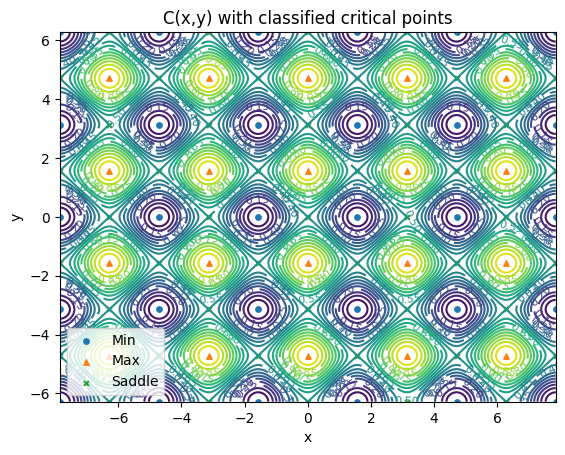

In [8]:


mins  = jnp.array([(x,y) for (x,y,_,t) in crit_pts if t=='local minimum'],  dtype=float)
maxs  = jnp.array([(x,y) for (x,y,_,t) in crit_pts if t=='local maximum'],  dtype=float)
sadds = jnp.array([(x,y) for (x,y,_,t) in crit_pts if t=='saddle / indefinite'], dtype=float)

plt.figure()
cs = plt.contour(XX, YY, C_grid, levels=20)
plt.clabel(cs, inline=True, fontsize=8)
if mins.size:  plt.scatter(mins[:,0],  mins[:,1],  s=15, marker='o', label='Min')
if maxs.size:  plt.scatter(maxs[:,0],  maxs[:,1],  s=15, marker='^', label='Max')
if sadds.size: plt.scatter(sadds[:,0], sadds[:,1], s=12, marker='x', label='Saddle')
plt.title('C(x,y) with classified critical points')
plt.xlabel('x'); plt.ylabel('y'); plt.legend(loc='lower left'); plt.show()


## Gradient descent/ascent
Updates:
- Descent: $r_{k+1} = r_k - \eta \, \nabla C(r_k)$
- Ascent:  $r_{k+1} = r_k + \eta \, \nabla C(r_k)$
We use `lax.scan` to keep it fast and optionally return the whole trajectory.

In [9]:
from jax import random
def project_to_box(r, xmin, xmax, ymin, ymax):
    return jnp.array([jnp.clip(r[0], xmin, xmax), jnp.clip(r[1], ymin, ymax)])
#gradient descent
@jax.jit
def gd_step(r, lr):
    return project_to_box(r - lr*gradC_vec(r), x_min, x_max, y_min, y_max)
#gradient ascent
@jax.jit
def ga_step(r, lr):
    return project_to_box(r + lr*gradC_vec(r), x_min, x_max, y_min, y_max)

def run_steps(step_fn, r0, lr=0.25, steps=120):
    def body(carry, _):
        r_next = step_fn(carry, lr)
        return r_next, r_next
    r0 = jnp.array(r0, dtype=jnp.float32)

    _, traj = lax.scan(body, r0, jnp.arange(steps))
    return jnp.vstack([r0, traj])


#
# Initialize a PRNG key with a fixed seed
key = random.PRNGKey(7)
key, kx, ky = random.split(key, 3)
x = random.uniform(kx, minval=float(x_min), maxval=float(x_max))
y = random.uniform(ky, minval=float(y_min), maxval=float(y_max))
start = jnp.array([x, y], dtype=jnp.float32)


start = jnp.array([x, y])
print("Random start:", start)
#Running Gradient Descent
path_min = run_steps(gd_step, start, lr=0.25, steps=120)
#Running Gradient Ascent
path_max = run_steps(ga_step, start, lr=0.25, steps=120)

print('Descent final:', path_min[-1], 'C =', float(C_vec_jit(path_min[-1])))
print('Ascent  final:', path_max[-1], 'C =', float(C_vec_jit(path_max[-1])))


Random start: [ 2.7509918 -3.6945388]
Descent final: [ 1.5707965 -3.141593 ] C = 6.635787568303603e-14
Ascent  final: [ 3.1415923 -4.712388 ] C = 1.0


## Plot Trajectories of gradient descent/ascent paths based on RNG key start

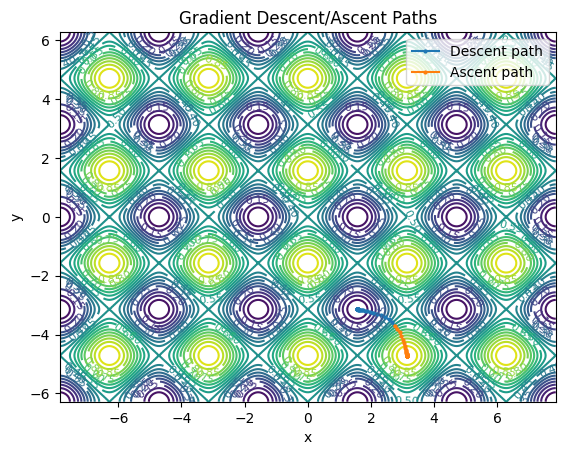

In [10]:
plt.figure()
cs = plt.contour(XX, YY, C_grid, levels=20)
plt.clabel(cs, inline=True, fontsize=8)

pm = np.array(path_min, dtype=float)
px = np.array(path_max, dtype=float)
plt.plot(pm[:,0], pm[:,1], marker='o', ms=2, label='Descent path')
plt.plot(px[:,0], px[:,1], marker='o', ms=2, label='Ascent path')
plt.title('Gradient Descent/Ascent Paths')
plt.xlabel('x'); plt.ylabel('y'); plt.legend(loc="upper right"); plt.show()
